**Problem:** Given a collection of trajectories from a stochastic process, and some alternative discretizations, we would like to perform model selection using cross-validated GMRQ. What happens if our train / test trajectories are in separate metastable regions?

In [1]:
# construct and simulate toy example: diffusive dynamics in a double-well potential

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

offset = np.array([3,0])

def q(x):
    ''' unnormalized probability '''
    return np.exp(-np.sum((x-offset)**2)) + np.exp(-np.sum((x+offset)**2))

def simulate_diffusion(x_0,q,step_size=0.01,max_steps=10000):
    ''' starting from x_0, simulate RW-MH '''
    traj = np.zeros((max_steps+1,len(x_0)))
    traj[0] = x_0
    old_q = q(x_0)
    
    for i in range(max_steps):
        
        prop = traj[i]+npr.randn(len(x_0))*step_size
        new_q = q(prop)

        if new_q/old_q>npr.rand():
            traj[i+1] = prop
            old_q = new_q
        else:
            traj[i+1] = traj[i]
            
    return traj

# collect some trajectories

npr.seed(0) # for repeatability

trajs = []
run_ids = []
for i,offset_ in enumerate([-offset,offset]): # analogous to 3 RUNs on Folding@Home
    for _ in range(10): # for each RUN, collect 10 clones
        trajs.append(simulate_diffusion(np.zeros(2)+offset_,q,max_steps=10000,step_size=0.1))
        run_ids.append(i)

In [2]:
len(trajs)

20

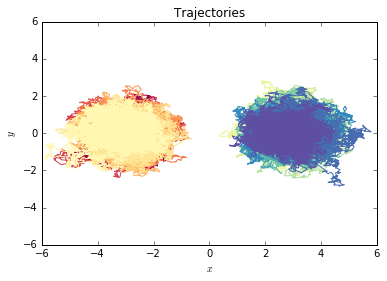

In [3]:
# plot trajectories

r = 6

def plot_trajectories(trajs,alpha=1.0):
    from matplotlib.pyplot import cm
    cmap = cm.get_cmap('Spectral')
    N = len(trajs)
    for i,traj in enumerate(trajs):
        c = cmap(float(i)/(N-1))
        plt.plot(traj[:,0],traj[:,1],color=c,alpha=alpha)
        
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.title('Trajectories')

    plt.xlim(-r,r)
    plt.ylim(-r,r)
plot_trajectories(trajs)

## Two candidate discretizations

In [4]:
n_bins=50

### Discretization_fast: finely resolving a fast DOF

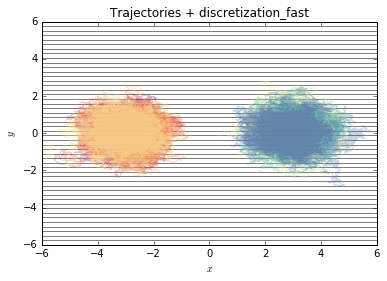

In [5]:
offsets = np.linspace(-r,r,n_bins)

plot_trajectories(trajs,alpha=0.3)

for offset in offsets:
    plt.hlines(offset,-r,r,colors='grey')
    

plt.xlim(-r,r)
plt.ylim(-r,r)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Trajectories + discretization_fast')

### Discretization_slow: finely resolving a slow DOF

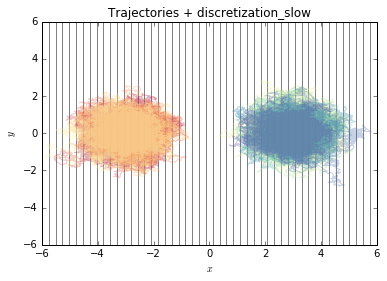

In [6]:
offsets = np.linspace(-r,r,n_bins)

plot_trajectories(trajs,alpha=0.3)

for offset in offsets:
    plt.vlines(offset,-r,r,colors='grey')
    

plt.xlim(-r,r)
plt.ylim(-r,r)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Trajectories + discretization_slow')

### Extract discrete trajectories

In [7]:
def axis_aligned_discretization(trajs,offsets,dim=0):
    dtrajs = []
    
    for traj in trajs:
        ax = traj[:,dim]
        
        bins = np.zeros((len(offsets)+1))
        bins[0] = -np.inf
        bins[1:] = offsets
        dtraj = np.digitize(ax,bins)
        dtrajs.append(dtraj)
        
    return dtrajs

dtrajs_fast = axis_aligned_discretization(trajs,offsets,dim=1)
dtrajs_slow = axis_aligned_discretization(trajs,offsets,dim=0)

In [8]:
from msmbuilder.msm import MarkovStateModel

In [9]:
m = 6 # how to choose m beforehand?

In [10]:
msm = MarkovStateModel(n_timescales=m)
msm.fit(dtrajs_fast)
msm.score_

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


6.6361862948096739

In [11]:
msm = MarkovStateModel(n_timescales=m)
msm.fit(dtrajs_slow)
msm.score_

MSM contains 2 strongly connected components above weight=1.00. Component 0 selected, with population 50.000000%


6.6250176569619779

## Cross-validation

In [12]:
def two_fold_cv(dtrajs,msm):
    train_scores = []
    test_scores = []
    
    split = len(dtrajs)/2
    
    A = dtrajs[:split]
    B = dtrajs[split:]
    
    msm.fit(A)
    train_scores.append(msm.score_)
    try:
        test_scores.append(msm.score(B))
    except:
        test_scores.append(np.nan)
    
    msm.fit(B)
    train_scores.append(msm.score_)
    try:
        test_scores.append(msm.score(A))
    except:
        test_scores.append(np.nan)
    
    return train_scores,test_scores

In [13]:
len(dtrajs_fast),len(dtrajs_slow)

(20, 20)

In [14]:
train_scores_fast, test_scores_fast = two_fold_cv(dtrajs_fast,msm)
train_scores_slow, test_scores_slow = two_fold_cv(dtrajs_slow,msm)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%


In [15]:
train_scores_fast, test_scores_fast

([6.5468650384820979, 6.6587841976518511],
 [6.5562637950341784, 6.5053699188617191])

In [16]:
train_scores_slow, test_scores_slow

([6.6250176569619779, 6.6153917624256913], [nan, nan])

In [17]:
np.mean(train_scores_fast), np.mean(test_scores_fast)

(6.6028246180669745, 6.5308168569479488)

In [18]:
np.mean(train_scores_slow), np.mean(test_scores_slow)

(6.6202047096938346, nan)

In [19]:
def leave_one_out_gmrq(dtrajs,msm):
    
    train_scores = []
    test_scores = []
    
    for i,test in enumerate(dtrajs):
        train = dtrajs[:i]+dtrajs[i+1:]
        msm.fit(train)
        train_scores.append(msm.score_)
        try:
            test_scores.append(msm.score(test))
        except:
            test_scores.append(np.nan)
        
    return train_scores,test_scores

In [20]:
train_scores_fast, test_scores_fast = leave_one_out_gmrq(dtrajs_fast,msm)
train_scores_slow, test_scores_slow = leave_one_out_gmrq(dtrajs_slow,msm)

MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=1.00. Component 0 selected, with popula

In [21]:
np.mean(train_scores_fast), np.mean(test_scores_fast)

(6.6366290414988258, 6.3005410516035001)

In [22]:
np.mean(train_scores_slow), np.mean(test_scores_slow)

(6.6202047096938328, nan)